<h1><center>Computational Astrophysics Report</center></h1>
<h2><center>Code Optimization</center></h2>
<h3><center> - Aditya Bhatt, Federico Braidi, Suprio Dubey</center></h3>


- ## 1. **Introduction**

The prediction of the motion of a group of celestial objects interacting with each other via gravitational forces is one of the classical challeges in physics and astronomy. The influence of the graviational force of each object to every other object makes it a complex problem. From the motion of the planets in our solar system, the formation of astrophysical structures and all the way upto the cosmological structures all of these are governed by  the equations of motion for N particles interacting gravitationally.<br>

In context of the astrophysical system of N particles interacting gravitationally the underlying dynamics is typically given by Newton's law .<br>
\begin{equation*}
   \frac{d^{2}\vec{x}_i}{dt^{2}} = - \sum_{j \ne i}  G \frac{m_j (\vec{x}_i-\vec{x}_j)}{|\vec{x_i}-\vec{x_j}|^3 }, \tag{1}
\end{equation*}
<br>
Eq.(1) as we can see is a system of $3 \times n$ non-linear second-order differential equation.But the question is, can we have an analytic answer for N bodies?
<br> 
While there are analytic solutions available for the classical (i.e. nonrelativistic) two-body problem and for selected configurations with $ n > 2$, in general n-body problems must be solved or simulated using numerical methods.
<br>

The primary challenge in the N-body simulations, lies in calculating the gravitational forces between all pairs of particles. As each particle interacts with every other particle, the force calculation involves a pairwise summation. Specifically, for $N$ particles, there are $N(N-1)/2$ unique pairs. This means that the computational complexity of the force calculation scales as $\mathcal{O}(N^2)$.

Let us consider a system with N particles. For each particle $i$:

1. We Calculate the distance to every other particle $j$.
2. Then Compute the gravitational force exerted by each particle $j$ on $i$.
3. Finally, sum these forces to determine the net force on particle $i$.

As the number of particles increases, the number of force calculations grows quadratically, making simulations with large $N$ computationally taxing which is a significant factor in the overall computational expense of $N$-body simulations.

In this project we work on developing the fireworks package for N-body simulation with the main focus on optimising the force calculation.
In the next section we breifly explain the packages in Fireworks which is followed by the description of the optimising techniques in section 3. In section 4. we conclude with our results.

## 2. **Fireworks**

The fireworks package contains the submodules:
 -  *ic*:
       This module contains function to generate various intial conditions for the simulation.This function outputs data to the Particles module, where the initial state of the particles is established.<br> 

 -  *particles*:
       This modules store the properties position, velocity, mass of the particles. It also includes methods to estimate the radius of all the particles,the module of the velociy of all the particles,the module the positition and velocity of the centre of mass. It also can be used to set an acceleration for each particle ,to estimate the total, kinetic and potential energy of the particles.Once the particles data is set up it is then passed to both the integrator and acceleration estimator function in dynamcis module.<br>


and the subpackage *nbodylib* contains the submodules:

 - *dynamics*:
   Contains a collection of functions to estimate acceleration due to gravitational  forces. The calculated acceleration can also be used to inform the Timestep Estimator. <br>
 
 - *timesteps*:
    Contains functions and utilities to estimate the timestep for the Nbody integrations.<br>

 - *integrator:*
   Contains a collection of integrators to integrate one step of the ordinary differential equation N-body problem.It uses the particle data and the timesteps to update the positions and velocities of the particles.This updated data is then looped back to the Particles module.<br>
 
 - *nunits*:
   Contains functions and utilities to deal with N-body units and units conversion.<br>

 - *potentials*:
   Contains a collection of classes and functions to estimate acceleration due to gravitational  forces of a fixed potential.<br>

Below is a flow diagram to show the functioning of the package.
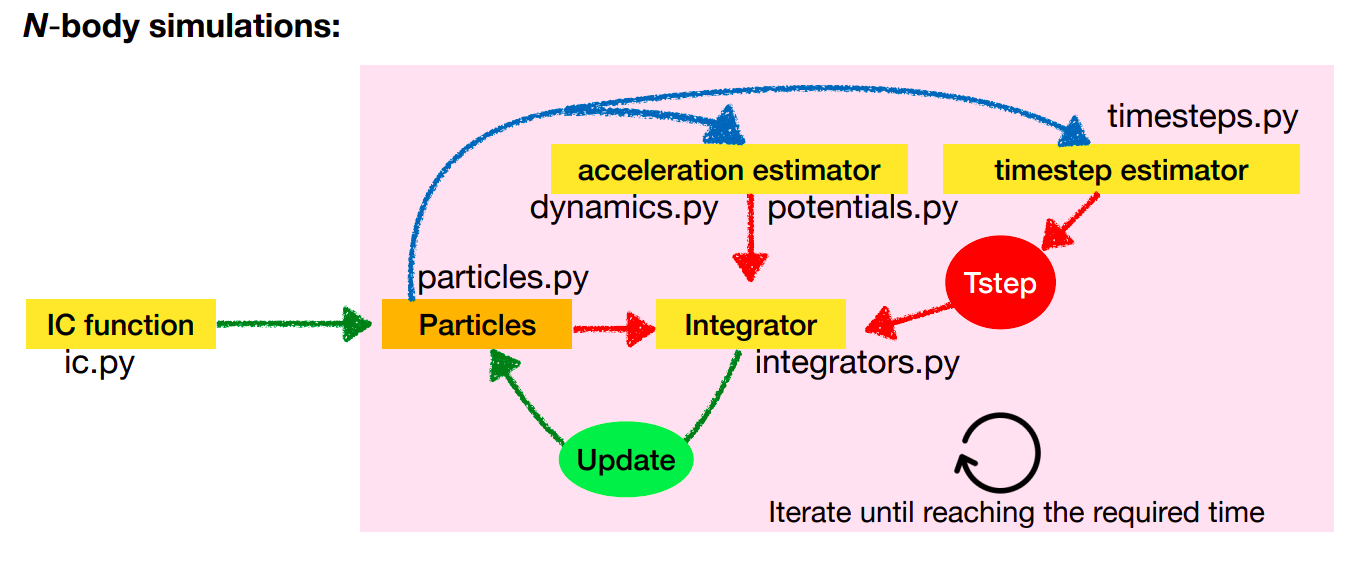(Credits: Guiliano Iorio) Fig 1.

## 3. **Optimization Techniques**

Before delving into the optimization techiniques we shortly discuss the acceleration direct function.

**acceleration_direct**
  
    for i in range(N):
        for j in range(i+1,N):
            #distances between particles i and j
            dx = particles.pos[i,0]-particles.pos[j,0]
            dy = particles.pos[i,1]-particles.pos[j,1]
            dz = particles.pos[i,2]-particles.pos[j,2]
            r = np.sqrt(dx**2 + dy**2 + dz**2)
            
            acc_ij = np.zeros(3)
            acc_ij[0] = dx / (r ** 3 + softening ** 3)
            acc_ij[1] = dy / (r ** 3 + softening ** 3)
            acc_ij[2] = dz / (r ** 3 + softening ** 3)

            #add accelleration to bodies
            for k in range(3):
                acc[i,k] -= acc_ij[k]*particles.mass[j]
                acc[j,k] += acc_ij[k]*particles.mass[i]



As we can see the function involves a nested loop (running on a single core), in which  the outer loop runs $N$ times (where $N$ is the number of particles) and the inner loop, on average, runs $(N-1)/2$ times for each iteration of the outer loop. Therefore, the total number of iterations is $N \times (N-1)/2 $, hence the time complexity $\mathcal{O}(N^2)$. So, as we increase $N$ the number of pairwise interactions grows quadratically taking up a significant computational time. Below , is a profile for an Nbody run of 9000 particles using cProfile, where we can observe that the bottleneck of the code is the acceleration_direct function consuming the maximum time.

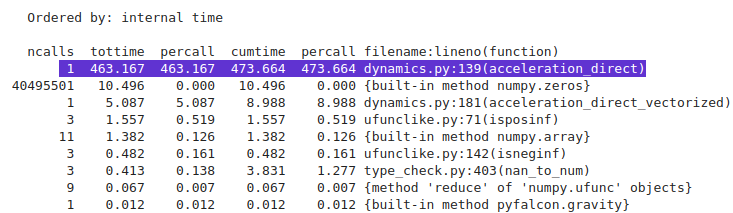

### 3.1 **Vectorization**

One way to optimize the code is by avoiding loops which consume time to check the loop conditions, increase the counter and access individual elements of the the arrays. We do that by using vectorizing the function as shown below.<br>

**acceleration_direct_vectorized**
    
    x = particles.pos[:,0:1]
    y = particles.pos[:,1:2]
    z = particles.pos[:,2:3]
    
    dx = x.T-x
    dy = y.T-y
    dz = z.T-z
    
    r = np.sqrt(dx**2+dy**2+dz**2)
    
    acc_x = np.sum(np.nan_to_num(dx * particles.mass / (r ** 3 + softening ** 3)), axis=1)
    acc_y = np.sum(np.nan_to_num(dy * particles.mass / (r ** 3 + softening ** 3)), axis=1)
    acc_z = np.sum(np.nan_to_num(dz * particles.mass / (r ** 3 + softening ** 3)), axis=1)
    acc = zip(acc_x,acc_y,acc_z)
    
    acc  = np.array(list(acc))

We first extract the positions of the particles along each axis, a column vector of shape $(N,1)$. Then, we compute the pairwise difference using NumPy's broadcasting, which helps to avoid the loops for calculating the piecewise interaction and significantly improves the compilation time, as we can see in the profile for N = 9000 particles below. 

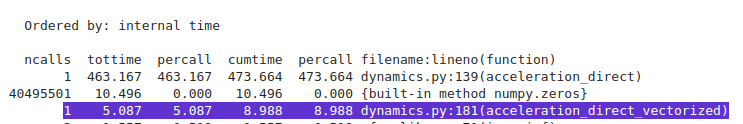



The plot below shows the Number of Particles vs the compilation plot where we see that on vectorising the compilation time improves by almost two orders for number of particles close to $10^{4}$.


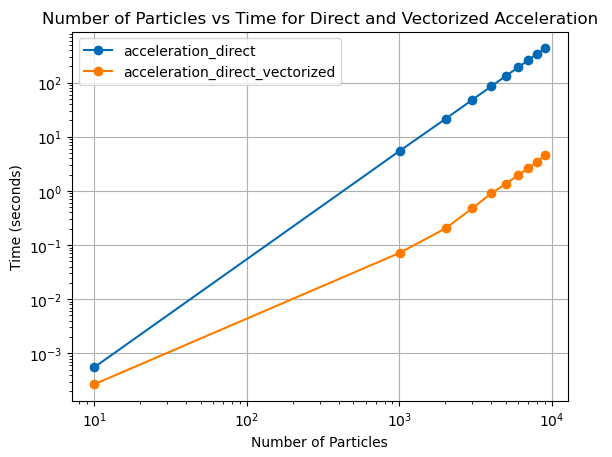 Fig 2.

### 3.2 **CPU Parallelization**

Although a significant improvement in the optimization is observed, further optimization was done using parallel processing to fully utilise the available 16 CPU cores .<br>

In CPU parallelization the computational task is divided into smaller subtasks that can be executed at the same time across multiple CPU cores. This technique takes advantage of modern multi-core processors that maximise energy efficiency and allow to run
multiple processes in parallel.<br> 

This can be exploited in two ways Multiprocessing and Multithreading.
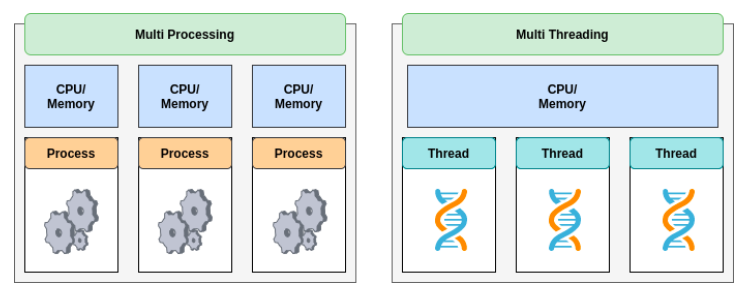 Fig 3.

- Multiprocessing involves using multiple independent simulations i.e. processes to execute tasks where each process runs in its own memory space, making it suitable for CPU-bound tasks. In this method, each process can operate independently without significant interprocess communication overhead.<br>

- Multithreading, on the other hand, involves multiple threads within a single process sharing the same memory space. A thread of execution is the smallest sequence of programmed instructions that can be managed independently within the operating system. This approach benefits I/O-bound tasks where threads can efficiently share data and resources. However, in CPU-bound tasks, multithreading may suffer from the Global Interpreter Lock (GIL) in Python where only one thread can be in a state of execution at any point in time.<br>

We use the multiprocessing module to parallelize the N-body simulation. This approach leverages the 16 cores available on our system to speed up the computation of particle interactions.



#### Implementing Parallel Processing Using Multiprocessing

We have implemented parallel processing for both the vectorized and direct acceleration functions. Below is a description of the code with a slight modification to adapt for the CPU parallelization.

    def parallel_vectorized_acc(s_index, e_index, shared_data):
        pos = shared_data['pos']
        N_particles = shared_data['N_particles']
        mass = shared_data['mass']
    
        dx = pos[s_index:e_index, 0, np.newaxis] - pos[:, 0]
        dy = pos[s_index:e_index, 1, np.newaxis] - pos[:, 1]
        dz = pos[s_index:e_index, 2, np.newaxis] - pos[:, 2]
    
        r = np.sqrt(dx**2 + dy**2 + dz**2)
        r[r == 0] = 1
    
        dist = np.concatenate((dx, dy, dz)).reshape((3, e_index - s_index, N_particles))
    
        acc = - (dist / r**3 @ mass).T
        jerk = None
        pot = None
    
        return acc, jerk, pot

    def parallel_vectorized_integrator(s_index, e_index, shared_data, tstep):
        vel = shared_data['vel']
        pos = shared_data['pos']
    
        acc, _, _ = parallel_vectorized_acc(s_index, e_index, shared_data)
        # print(f"parallel vect:\n{acc}")
    
        vel[s_index:e_index] = vel[s_index:e_index] + acc * tstep
        pos[s_index:e_index] = pos[s_index:e_index] + vel[s_index:e_index] * tstep
    
        shared_data['vel'][s_index:e_index] = vel[s_index:e_index]
        shared_data['pos'][s_index:e_index] = pos[s_index:e_index]
    
        return pos[s_index:e_index], vel[s_index:e_index]
    
    def parallel_acceleration_direct(s_index, e_index, shared_data):
        pos = shared_data['pos']
        N_particles = shared_data['N_particles']
        mass = shared_data['mass']
    
        dim_batch = e_index - s_index
        acc = np.zeros((dim_batch, 3))
    
        for i in range(dim_batch):
            for j in range(N_particles):
                if j != i:
                    dx = pos[s_index + i, 0] - pos[j, 0]
                    dy = pos[s_index + i, 1] - pos[j, 1]
                    dz = pos[s_index + i, 2] - pos[j, 2]
    
                    r = np.sqrt(dx**2 + dy**2 + dz**2)
                    if r == 0:
                        r = 1
    
                    acc_ij = np.zeros(3)
                    acc_ij[0] = dx / (r ** 3)
                    acc_ij[1] = dy / (r ** 3)
                    acc_ij[2] = dz / (r ** 3)
    
                    for k in range(3):
                        acc[i, k] -= acc_ij[k] * mass[j]
    
        return acc, None, None
    

    def parallel_direct_integrator(s_index, e_index, shared_data, tstep):
        vel = shared_data['vel']
        pos = shared_data['pos']
    
        acc, _, _ = parallel_acceleration_direct(s_index, e_index, shared_data)
        # print(f"parallel direct:\n{acc}")
        vel[s_index:e_index] = vel[s_index:e_index] + acc * tstep
        pos[s_index:e_index] = pos[s_index:e_index] + vel[s_index:e_index] * tstep
    
        shared_data['vel'][s_index:e_index] = vel[s_index:e_index]
        shared_data['pos'][s_index:e_index] = pos[s_index:e_index]
    
        return pos[s_index:e_index], vel[s_index:e_index]

 This is done to compartmentalize the work in $N$ parts(with $N$ being the number of available cores). We implement a check to compare if the number of cores or the number of particles is higher.<br>
- If the number of particles is less than or equal to the number of available cores, we assigned one particle per core, using as many cores as there were particles.<br>
- If the number of particles is greater than the number of cores, we divide the particles into batches, assigning each batch to a different core.<br>

We then initialize a pool with a specific number of processes corresponding to the number of available CPU cores and use pool.starmap_async from the multiprocessing library to run the parallel versions of the acceleration functions simultaneously.<br>

The parallel vectorized function is derived from the non-parallel one by adding a start and end index to the needed parameters, which are used within each process to subset the particles and only calculate the accelerations for those in the subset.
A similar approach is used for non-vectorized parallel acceleration. In this second case, however, while we gain computational time as a result of parallelization, we also lose a useful technique that we implemented in the non-parallel version: we were only calculating the acceleration due to the particles' pairwise interaction once and updating both particles simultaneously. Now, because we have subsetted the particles to allow for parallelization, every process calculates the effect of all other particles.

    def parallel_vectorized_evo(N_particles, total_evo_time, N_CORES):
        global pos, vel, mass
    
        N_PROCESSES = min(N_CORES, N_particles)
    
        with Manager() as manager:
            shared_data = manager.dict()
            shared_data['pos'] = pos
            shared_data['vel'] = vel
            shared_data['mass'] = mass
            shared_data['N_particles'] = N_particles
    
            pool = Pool(N_PROCESSES)
            tstep = 0.01
    
            positions = []
            process = psutil.Process()
            memory_usages = []
    
            for _ in range(int(total_evo_time / tstep)):
                start_memory = process.memory_info().rss
    
                if N_particles < N_CORES:
                    future_results = pool.starmap_async(parallel_vectorized_integrator, 
                                                        [(i, (i + 1), shared_data, tstep) for i in range(N_particles)])
                else:
                    future_results = pool.starmap_async(parallel_vectorized_integrator, 
                                                        [(i * N_particles // N_PROCESSES, (i + 1) * N_particles // N_PROCESSES, shared_data, tstep) for i in range(N_PROCESSES)])
    
                results = future_results.get()
                pos = np.concatenate([results[i][0] for i in range(len(results))])
                vel = np.concatenate([results[i][1] for i in range(len(results))])
                shared_data['pos'] = pos
                shared_data['vel'] = vel
    
                positions.append(pos)
    
                end_memory = process.memory_info().rss
                memory_usages.append(end_memory - start_memory)
    
            pool.close()
            pool.join()
    
        return positions, memory_usages
       
        ###################################################################################################
    
    
    def parallel_direct_evo(N_particles, total_evo_time, N_CORES):
        global pos, vel, mass
    
        N_PROCESSES = min(N_CORES, N_particles)
    
        with Manager() as manager:
            shared_data = manager.dict()
            shared_data['pos'] = pos
            shared_data['vel'] = vel
            shared_data['mass'] = mass
            shared_data['N_particles'] = N_particles
    
            pool = Pool(N_PROCESSES)
            tstep = 0.01
    
            positions = []
            process = psutil.Process()
            memory_usages = []
    
            for _ in range(int(total_evo_time / tstep)):
                start_memory = process.memory_info().rss
    
                if N_particles < N_CORES:
                    future_results = pool.starmap_async(parallel_direct_integrator, 
                                                        [(i, (i + 1), shared_data, tstep) for i in range(N_particles)])
                else:
                    future_results = pool.starmap_async(parallel_direct_integrator, 
                    [(i * N_particles // N_PROCESSES,(i + 1) * N_particles // N_PROCESSES, shared_data, tstep) for i in range(N_PROCESSES)])
    
                results = future_results.get()
                pos = np.concatenate([results[i][0] for i in range(len(results))])
                vel = np.concatenate([results[i][1] for i in range(len(results))])
                shared_data['pos'] = pos
                shared_data['vel'] = vel
    
                positions.append(pos)
    
                end_memory = process.memory_info().rss
                memory_usages.append(end_memory - start_memory)
    
            pool.close()
            pool.join()
    
        return positions, memory_usages


<!-- 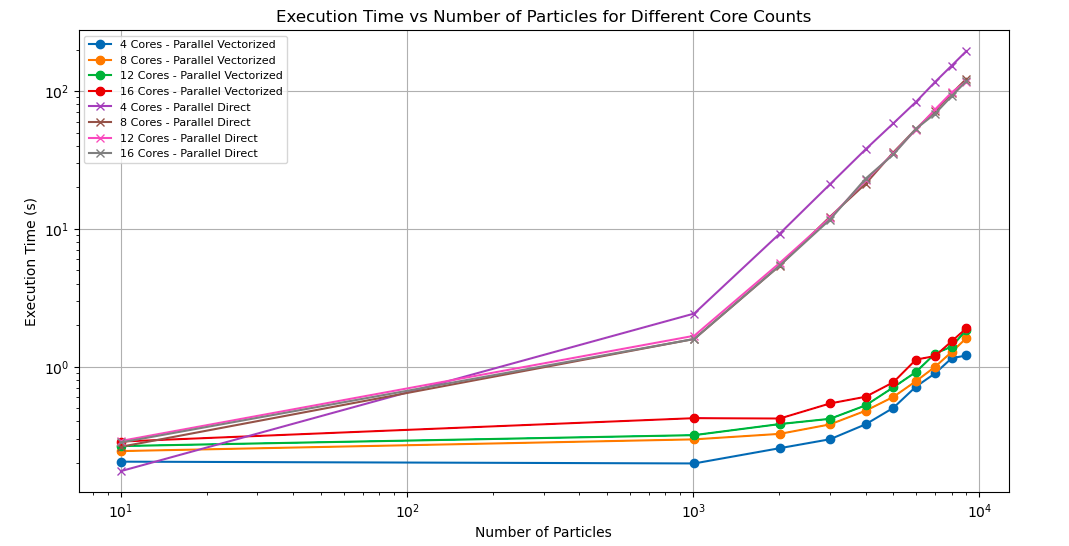 -->

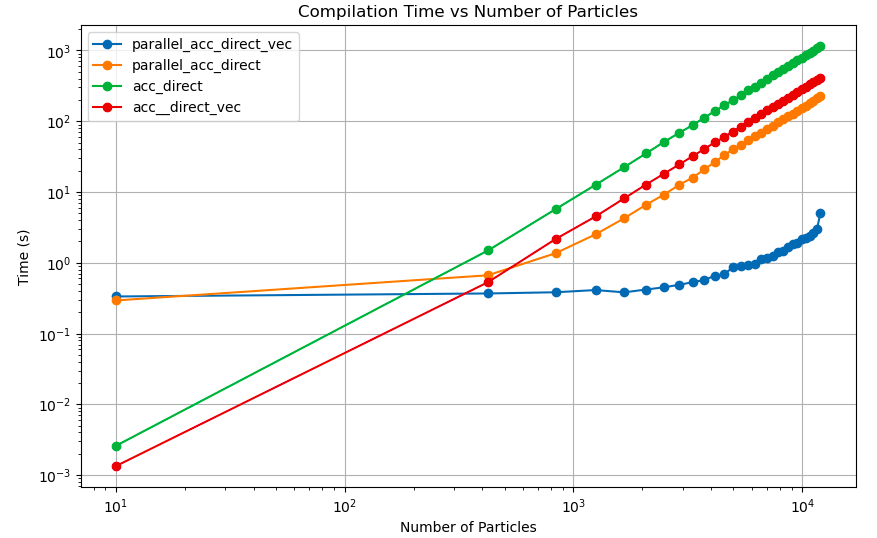 Fig 4.

In the plot above  we see the performance of the  CPU parallelization using multiprocessing with respect to "__acceleration_direct__" and "__acc_direct_vectorised__". We observe that for a lower number of particles, the functions without the parallelization perform better. This can be seen from the cprofiles below for 500 particles that in case of parallelization some time is taken to create new processes for parallel execution *{built-in method posix.fork}*. This time taken is significant for smaller workload i.e. forming a small number of particles than implementing it without parallelization. But as we increase the number of particles we can reap the benefits of parallelization and it  starts to outweigh the overhead.




**acc_direct_vectorised** 

  
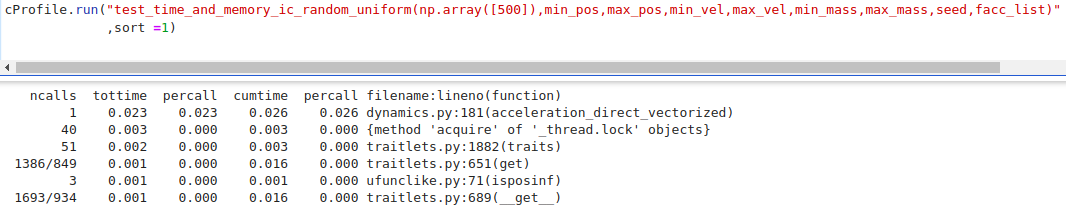

**parallel_acc_direct_vectorised**



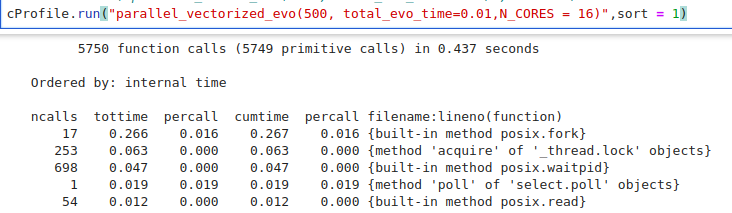

### 3.3 **GPU Parallelization**


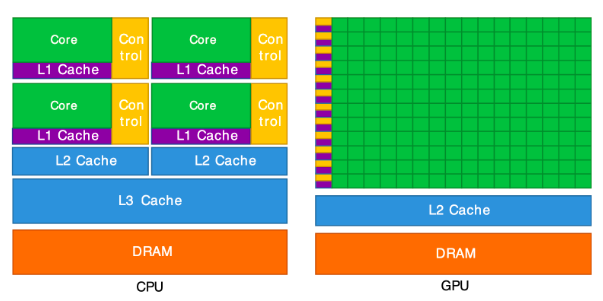 Fig 5.


Another approach we used for optimization was using GPUs for parallelization. In contrast to CPUs which have fewer cores but are designed to be very powerful and capable of handling complex tasks, GPUs contain a large number of simpler cores compared to CPUs. By working together, the cores deliver massive performance in parallelizing across these cores. This inherent parallelism can be exploited to calculate the force by distributing the tasks of calculating the force particle across multiple GPU cores. In the diagram below we can see the calculation of the forces for N bodies where each thread on the GPU can evaluate the force on the particle i, due to the particle j (where j represents the GPU j-thread).



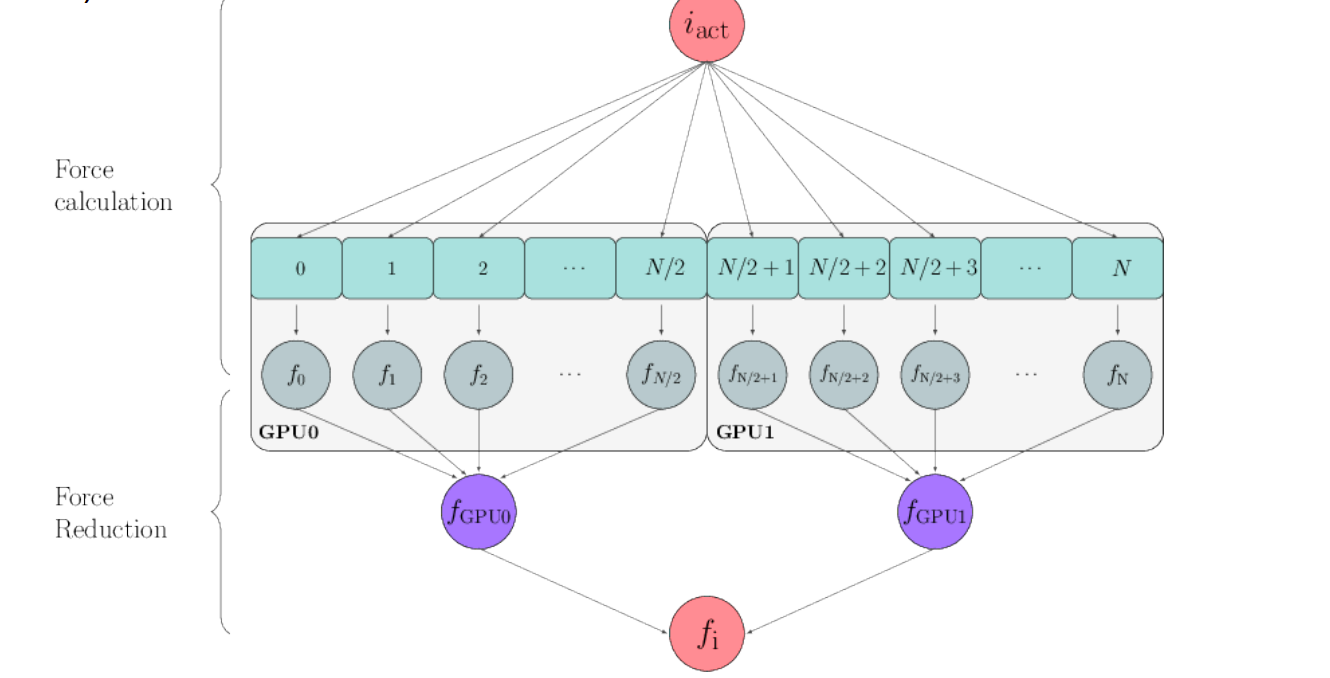 Fig 6.

To take advantage of GPU acceleration, we used Tensorflow (https://www.tensorflow.org/guide/basics). Tensorflow enables us to implement two critical strategies for enhanced performance.

- It supports distributed computations across several CPU cores and GPUs.

- Multidimensional data is handled using multidimensional arrays or tensors. 



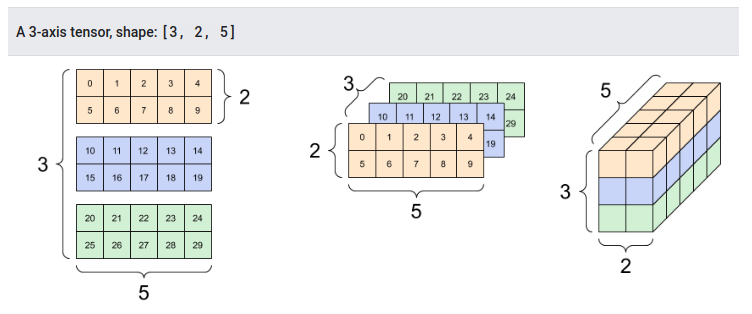 Fig 7.



We can execute element-wise operations on tensors, which means that each element is treated independently and is consistent with the parallel processing architecture of GPUs.  Element-wise operations distribute the workload across thousands of cores, with each core only capable of executing a single operation very quickly. Each core is assigned a separate element in the tensor operation, and all cores conduct calculations at once.<br>

TensorFlow performs tensor computations via computational graphs. Nodes represent operations, variables, or placeholders, while edges represent the tensors that flow between them i.e. they carry information from one node to the other. TensorFlow builds this graph and optimizes it for optimal execution. The advantage of using computational graphs is that they exclusively specify how the outputs of these operations flow from one operation to another. This helps with executing parallelism for example in the graph below the multiplication and addition can be executed in parallel.

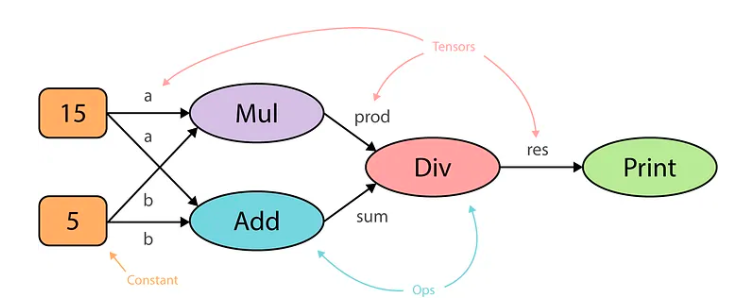 Fig 8.

Now, after going through some basics of TensorFlow, we will go through the changes made in the fireworks module to implement GPU parallelization using tensors.

Firstly, We defined a separate class in the _particles_ submodule called Particles_tf which contains the same operations as in the class Particles but we use TensorFlow tensors instead of NumPy arrays and use tensor operations.

    class Particles_tf:
        
        def _convert_to_tensor(self, data):                       
            if isinstance(data, np.ndarray):
                print("np---> tf")
                return tf.convert_to_tensor(data, dtype=tf.float32)  ##  Converts NumPy array into tensors
            elif isinstance(data, tf.Tensor):
                return tf.cast(data, dtype=tf.float32)
            else:
                raise ValueError("Unsupported data type. Must be either a NumPy array or a TensorFlow tensor.")
    
        def __init__(self, position, velocity, mass):
            self.pos = self._convert_to_tensor(position)
            self.vel = self._convert_to_tensor(velocity)
            self.mass = self._convert_to_tensor(mass)
            self.ID = tf.range(tf.shape(mass)[0], dtype=tf.int32)
            self.acc = None
        
        def set_acc(self, acceleration):
            self.acc = self._convert_to_tensor(acceleration)
    
        def radius(self):
            return tf.sqrt(tf.reduce_sum(self.pos * self.pos, axis=1))

            .
            .
            .
            .
        def Ekin(self):
            return tf.reduce_sum(0.5 * self.mass * tf.reduce_sum(self.vel * self.vel, axis=1))
        
        def Epot_tf(self, softening: float = 0., G: float = 1.):
            pos = self.pos
            mass = self.mass
            N = len(mass)
        
            # Expand dimensions for broadcasting
            pos_i = tf.expand_dims(pos, axis=0)
            pos_j = tf.expand_dims(pos, axis=1)
            mass_i = tf.expand_dims(mass, axis=0)
            mass_j = tf.expand_dims(mass, axis=1)
        
            dr = pos_i - pos_j
            r_ij = tf.norm(dr, axis=-1)  # Compute norm along the last axis
        
            # Compute potential energy using broadcasting
            PE = -(mass_i * mass_j) / tf.sqrt(r_ij**2 + softening**2)
        
            # Excludes self-interaction terms and sum the result
            mask = tf.math.logical_not(tf.eye(N, dtype=tf.bool))
            E_pot = tf.reduce_sum(tf.boolean_mask(PE, mask))/2
        
            return E_pot


Then we define a function acceleration_tf which estimates the acceleration using TensorFlow operations and use the instance of class Particles_tf from the _particles_ module.

    def acceleration_tf(particles: Particles_tf, softening: float = 0., potential: bool = False) \
            -> Tuple[tf.Tensor, Optional[tf.Tensor], Optional[tf.Tensor]]:
        
        pos = particles.pos
        mass = particles.mass
    
        x = pos[:, 0:1]
        y = pos[:, 1:2]
        z = pos[:, 2:3]
        
        dx = tf.transpose(x) - x
        dy = tf.transpose(y) - y
        dz = tf.transpose(z) - z
    
        r_squared = dx ** 2 + dy ** 2 + dz ** 2
        epsilon = tf.constant(softening, dtype=tf.float32)
        r_inv_cube = tf.math.rsqrt(r_squared + epsilon) ** 3
    
        acc_x = tf.reduce_sum(dx * r_inv_cube * mass, axis=1)
        acc_y = tf.reduce_sum(dy * r_inv_cube * mass, axis=1)
        acc_z = tf.reduce_sum(dz * r_inv_cube * mass, axis=1)
        acc = tf.stack([acc_x, acc_y, acc_z], axis=1)
    
        jerk = None
        pot = particles.Epot_tf(softening=softening) if potential else None
        # print(f"potential inside dynamics  is {pot}")
    
        return acc, jerk, pot if potential else None

We start by separating the coordinates into individual tensors from the particle positions. Then we compute the pairwise difference along each coordinate. We do that by changing the shape of the tensor from $(N,1)$ to $(1, N)$  using _tf.transpose()_ and then take the difference by broadcasting to match the shape to $(N, N)$. After that, we calculate the distance  between each pair and calculate the acceleration along each axis for each pair of particles and then use _tf.reduce_sum()_ along the column i.e axis = 1.

We run the TensorFlow implemented code in both CPU and GPU and we get a significant optimization for a higher number of particles over **acceleration_direct** and **acceleration_direct_vec** functions.


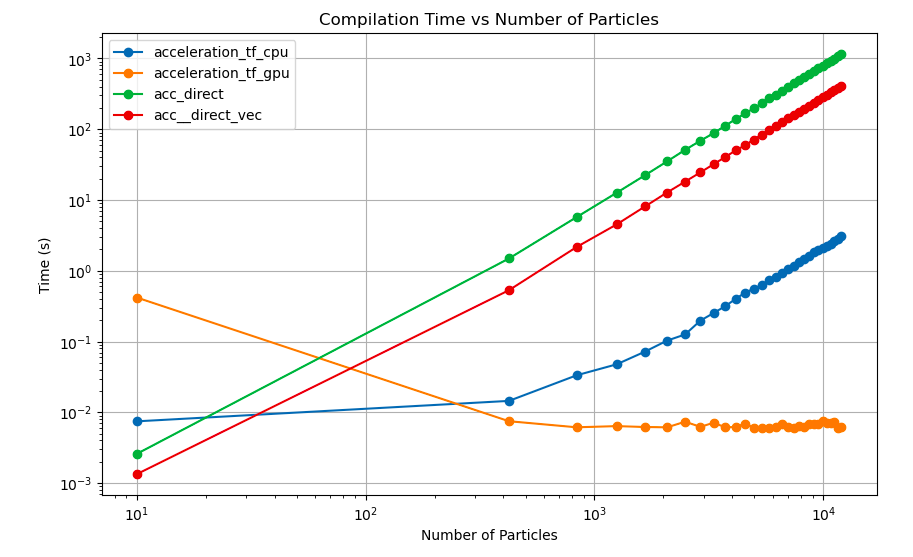 Fig 9.

However we can observe that for particles less than 100 GPU parallelization takes significantly more time than the other methods. To understand this we used cProfile for the **acceleration_tf** function for 10 particles.

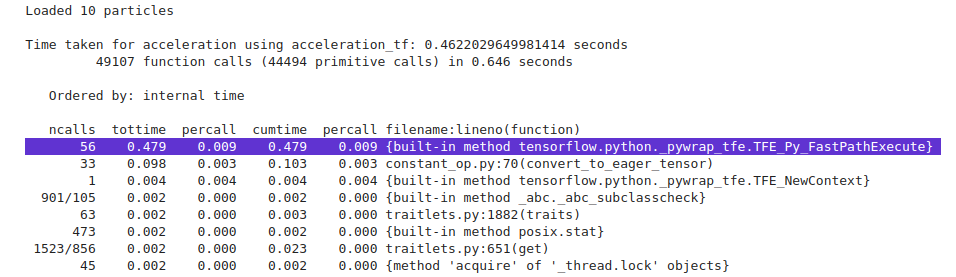

We observe that the majority of the time spent is attributed to the internal TensorFlow function that initializes and executes computational graphs. We tested the function with fewer particles (between 1 and 100) to confirm this, and we found that the most time-consuming portion of the process is indeed initializing the computational graphs.

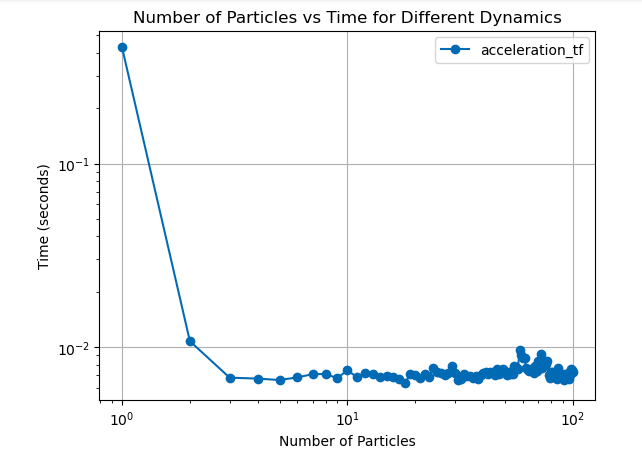 Fig 10.


Considering that the computational graphs have already been initialized, we also attempted to investigate whether subsequently running the code for the same amount of particles might yield better results. In fact, we see that the compilation time has decreased.



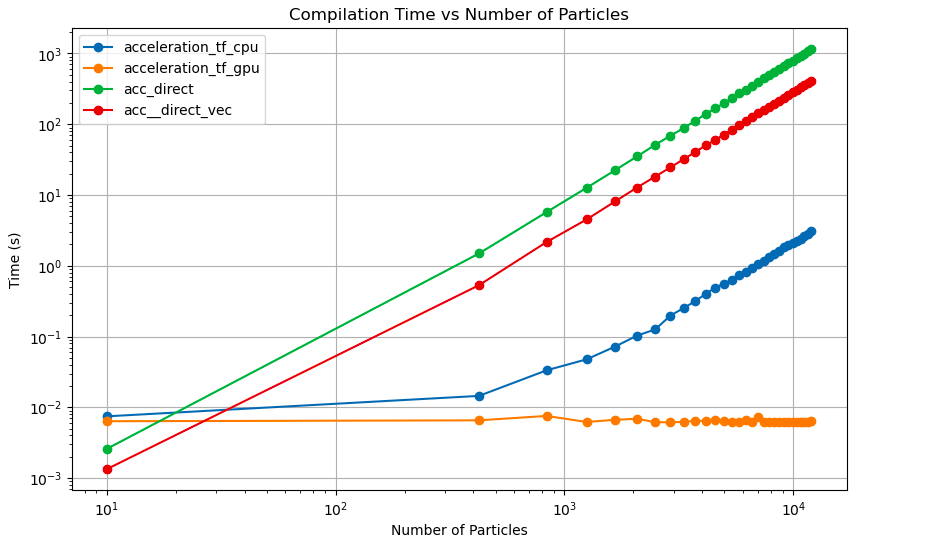Fig 11.

## 4. __CONCLUSION__

In this work, we attempted to use both CPU and GPU parallelization to optimise the force computation in the fireworks package. For the task, we employed TensorFlow and multiprocessing, respectively. In terms of CPU parallelization, we discover that the compilation time of the code is improved when multiprocessing is used to parallelize **acceleration direct vectorized** and **acceleration direct**; the former offers an improvement of roughly order 3, while the latter doesn't yield a discernible improvement.We also implemented a tensor-based parallelization technique using Tensorflow for CPU parallelization. Up to $3 \times 10^{3}$, it outperforms parallelized **acceleration direct vectorized** and nearly converges to comparable compilation times as we increase the number of particles.For Gpu We observe that PyFalcon provides the best optimisation for particles below $3 \times 10^{3}$. However, as the number of particles increases, GPU parallelization using TensorFlow yields the best compilation time.

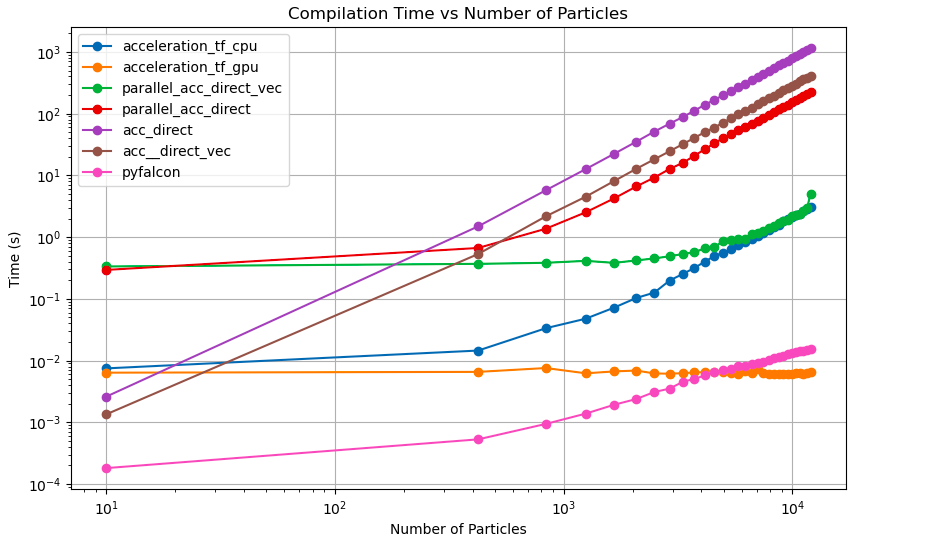Fig 12.